In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import umap
from sklearn.manifold import TSNE
import re

c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from main import get_last_data_path
data_dir = "data"
data_path = get_last_data_path(data_dir)

with open(data_path, "rb") as f:
    data = pickle.load(f)

c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [3]:
from consts import GEMMA_2
gemma_2_data = data[GEMMA_2]

In [4]:
class_names = ['vector', 'mlp', 'attn', 'resid']
name_mapping = {'vector': 0, 'mlp': 1, 'attn': 2}#, 'resid': 3}
all_vectors = []
mlp_vs_attn = []

for steering_vector, per_vector_data in gemma_2_data.items():
    current_vectors = []
    current_mlp_vs_attn = []

    vec = per_vector_data['meta']['direction']
    current_vectors.append(vec.float())
    current_mlp_vs_attn.append(name_mapping['vector'])
    data_at_position = per_vector_data['all']
    negative_outputs_train, positive_outputs_train, negative_outputs_test, positive_outputs_test = data_at_position
    negative_dots_train, negative_norms_train, negative_agg_train = negative_outputs_train
    positive_dots_train, positive_norms_train, positive_agg_train = positive_outputs_train

    for component_name in negative_agg_train.keys():
        diff_means = positive_agg_train[component_name] - negative_agg_train[component_name]

        if 'ln2' in component_name:
            current_mlp_vs_attn.append(name_mapping['mlp'])
            current_vectors.append(diff_means.float())

        elif 'ln1' in component_name:
            current_mlp_vs_attn.append(name_mapping['attn'])
            current_vectors.append(diff_means.float())

    current_vectors = np.array(current_vectors)
    all_vectors.append(current_vectors)
    mlp_vs_attn.append(current_mlp_vs_attn)

all_vectors = np.array(all_vectors)
all_vectors = all_vectors.transpose(1,0,2)
per_steering_vector = all_vectors.copy()
all_vectors = all_vectors.reshape(all_vectors.shape[0], -1)

mlp_vs_attn = np.array(mlp_vs_attn)[0]

In [5]:
def run_tsne_umap(vectors, is_cosine=True):
    print("Running t-SNE...")
    if is_cosine:
        tsne = TSNE(n_components=2, perplexity=10, random_state=42, metric='cosine')
    else:
        tsne = TSNE(n_components=2, perplexity=10, random_state=42)
    X_tsne = tsne.fit_transform(vectors)

    print("\nRunning UMAP...")
    if is_cosine:
        reducer = umap.UMAP(n_neighbors=3, min_dist=0.1, n_components=2, random_state=42, metric='cosine')
    else:
        reducer = umap.UMAP(n_neighbors=3, min_dist=0.1, n_components=2, random_state=42)
    X_umap = reducer.fit_transform(vectors)

    return X_tsne, X_umap

In [6]:
def create_graph(X, tsne=False, id=None):
    plt.rcParams.update({
        "font.size": 10,
        "axes.labelsize": 10,
        "axes.titlesize": 12,
        "legend.fontsize": 10,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "figure.figsize": (10, 7),
    })

    method_name = 't-SNE' if tsne else 'UMAP'

    _, ax = plt.subplots()

    colors = ['#E41A1C',  # Red
              '#56B4E9',  # Blue
              '#006400']  # Green

    markers = ['o', 's', '^', 'D']  # Circle, square, triangle, diamond

    for i, cls in enumerate(np.unique(mlp_vs_attn)):
        mask = mlp_vs_attn == cls
        ax.scatter(
            X[mask, 0], X[mask, 1],
            color=colors[i], marker=markers[i],
            alpha=0.85, label=class_names[i], edgecolor='black', linewidth=0.4
        )
    ax.set_title(f'{method_name} Visualization')
    ax.set_xlabel(f'{method_name} Component 1')
    ax.set_ylabel(f'{method_name} Component 2')
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.legend(frameon=True)

    plt.suptitle(f'{method_name}: Steering Vector Components', fontsize=12)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Save ACL-ready vector file
    plt.savefig(f"{method_name}_acl_{id if id else ''}.pdf", bbox_inches="tight")

    plt.show()

Running t-SNE...

Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


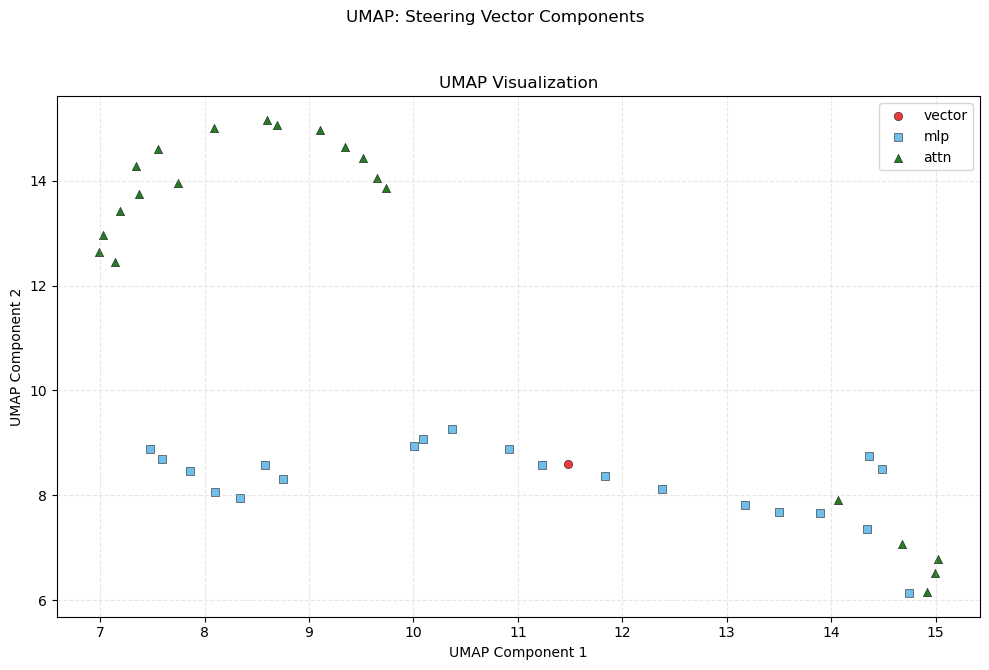

In [7]:
# RUN FOR COSINE SIMILARITY
X_tsne, X_umap = run_tsne_umap(all_vectors)
create_graph(X_umap)

Running t-SNE...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)



Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


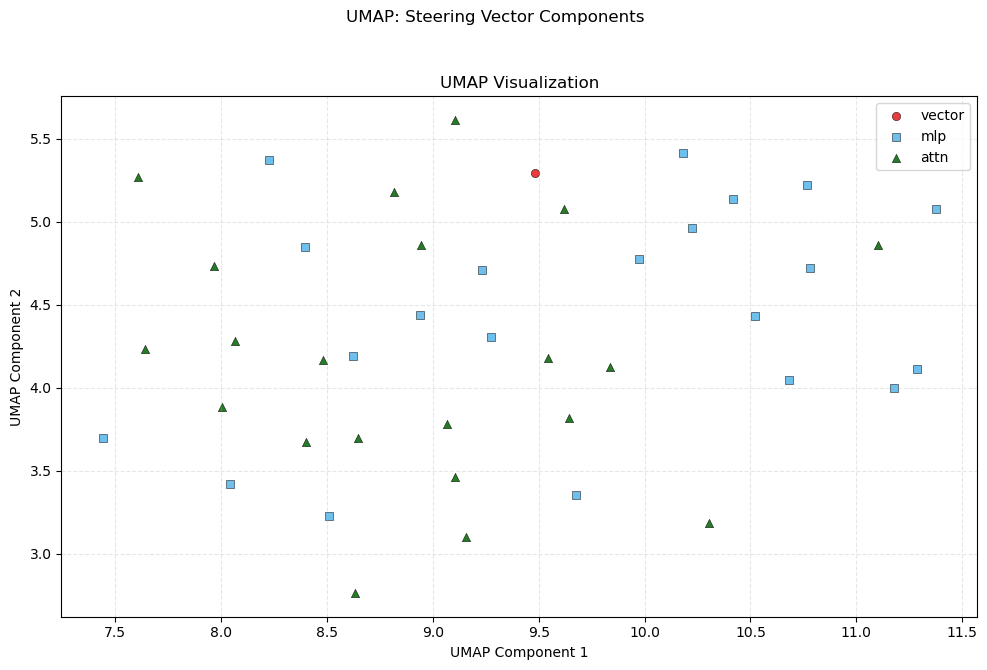

In [8]:
# RUN FOR EUCLIDEAN DISTANCE
X_tsne, X_umap = run_tsne_umap(all_vectors,is_cosine=False)
create_graph(X_umap)

Running t-SNE...

Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


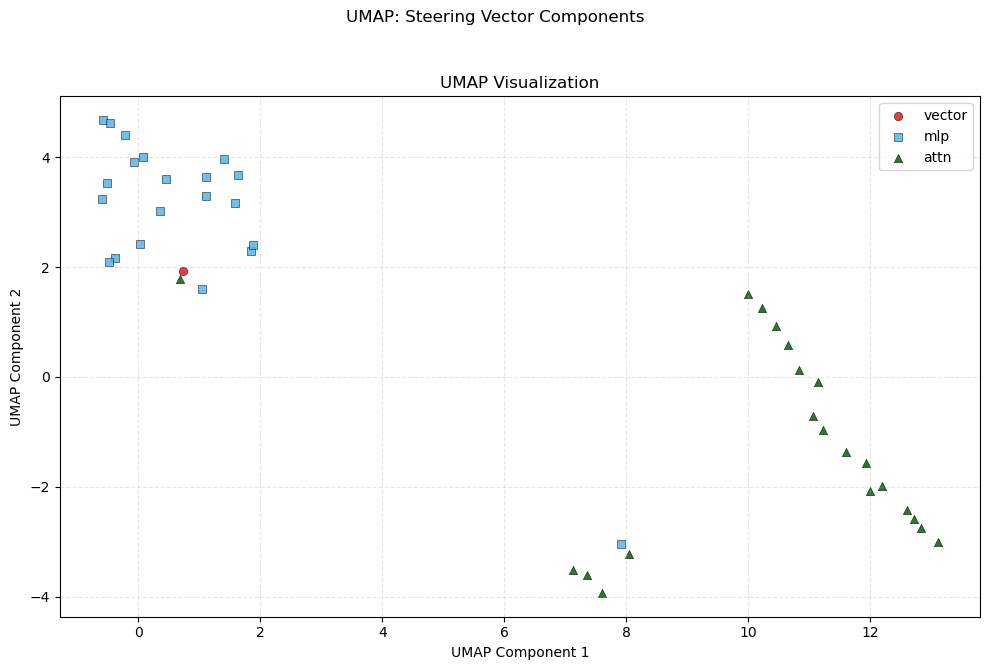

[[ 0.68422127  1.7843192 ]
 [ 7.123594   -3.5152378 ]
 [ 7.354467   -3.6060023 ]
 [ 7.5933375  -3.9348018 ]
 [ 8.039595   -3.2267976 ]
 [11.999304   -2.084778  ]
 [12.705961   -2.5833178 ]
 [12.596441   -2.422151  ]
 [11.050387   -0.7172035 ]
 [12.180878   -1.991198  ]
 [11.214405   -0.96997875]
 [11.925291   -1.5701813 ]
 [ 9.995644    1.5084955 ]
 [11.598746   -1.3719201 ]
 [10.224156    1.2497141 ]
 [12.822292   -2.7461152 ]
 [11.138539   -0.08480126]
 [10.443085    0.9214421 ]
 [10.827233    0.13103439]
 [13.10986    -3.0107121 ]
 [10.642475    0.57478446]]
Running t-SNE...

Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


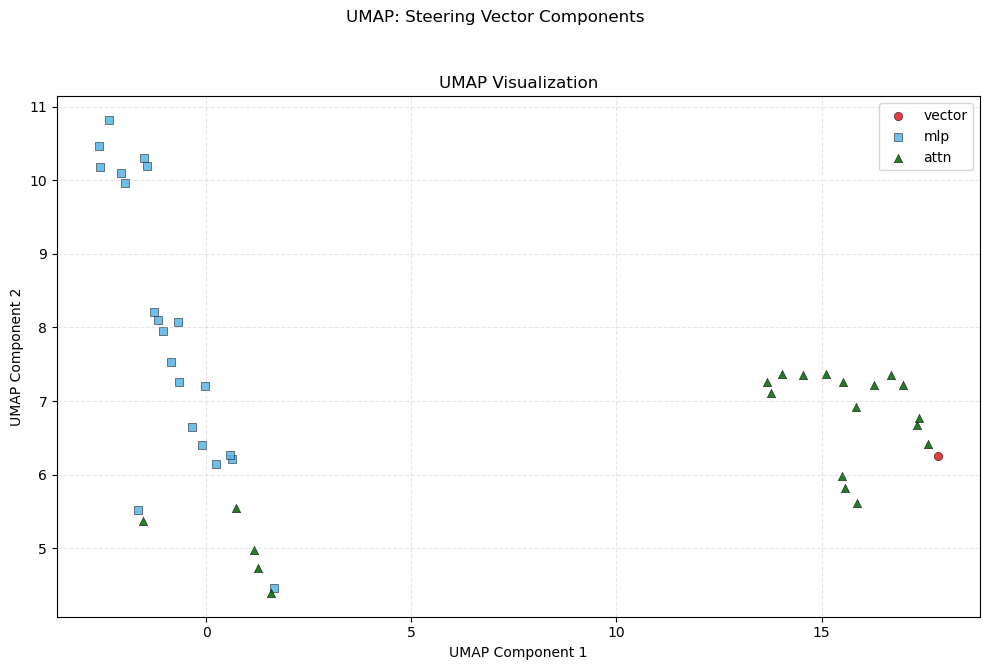

[[ 0.73162425  5.5496554 ]
 [ 1.1521467   4.9722023 ]
 [ 1.2549706   4.7235694 ]
 [-1.5456582   5.3630667 ]
 [ 1.5693047   4.387645  ]
 [15.84965     6.9159994 ]
 [13.77519     7.1110487 ]
 [14.542802    7.3602543 ]
 [16.988789    7.2178955 ]
 [15.097347    7.370204  ]
 [16.691204    7.347661  ]
 [15.529438    7.2582603 ]
 [15.494181    5.980976  ]
 [16.284256    7.2213216 ]
 [15.580206    5.823247  ]
 [14.023329    7.3684754 ]
 [17.331566    6.6750813 ]
 [15.863354    5.6087847 ]
 [17.369991    6.7644143 ]
 [13.661188    7.252824  ]
 [17.600956    6.413459  ]]
Running t-SNE...

Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


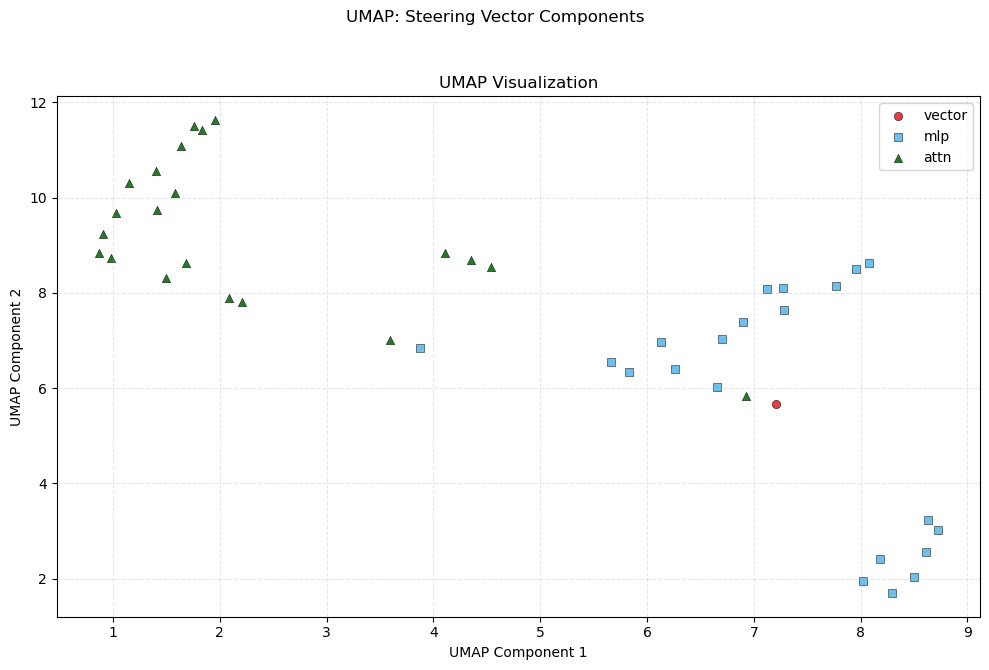

[[ 6.9250293   5.8423347 ]
 [ 4.54183     8.544004  ]
 [ 4.3550024   8.685906  ]
 [ 4.110219    8.839191  ]
 [ 3.593501    7.011358  ]
 [ 0.8691946   8.834234  ]
 [ 1.6793677   8.619502  ]
 [ 1.4994922   8.310294  ]
 [ 1.5797992  10.0985365 ]
 [ 0.97871727  8.731744  ]
 [ 1.4105873   9.730759  ]
 [ 0.904946    9.231738  ]
 [ 1.7582341  11.511253  ]
 [ 1.0322896   9.667083  ]
 [ 1.9511154  11.629039  ]
 [ 2.082133    7.8877482 ]
 [ 1.1547866  10.312136  ]
 [ 1.8344052  11.42719   ]
 [ 1.4043857  10.548327  ]
 [ 2.2102785   7.812995  ]
 [ 1.6390318  11.092386  ]]
Running t-SNE...

Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


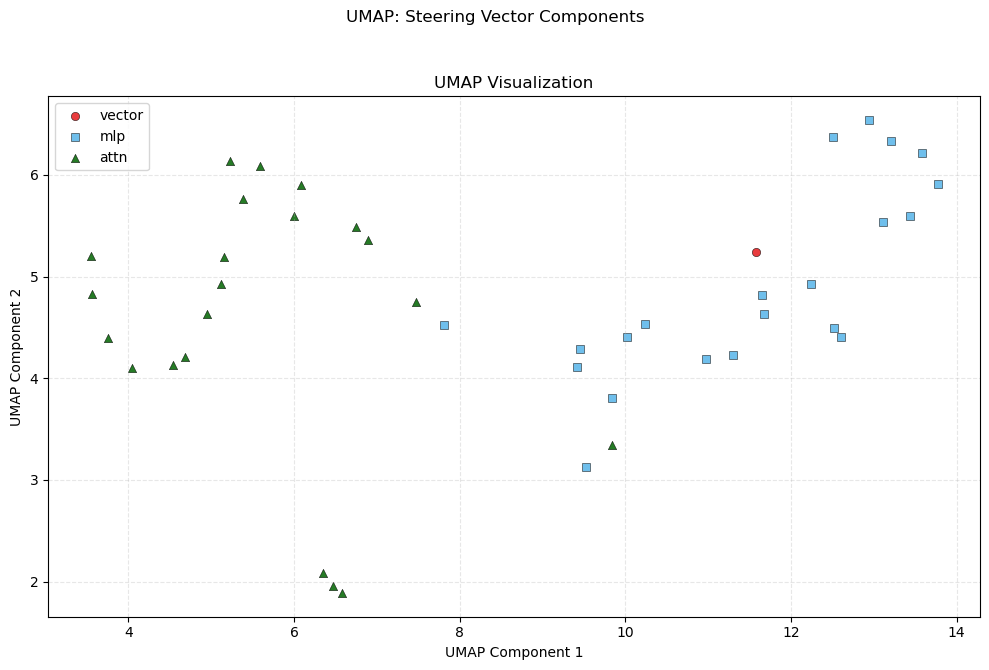

[[9.836448  3.3484168]
 [6.583971  1.888061 ]
 [6.4697714 1.9622169]
 [6.3476043 2.081814 ]
 [7.474725  4.7522626]
 [5.231623  6.1340604]
 [6.0044928 5.6000485]
 [6.083721  5.9015303]
 [4.9498734 4.6370335]
 [5.593191  6.0840907]
 [5.1237254 4.9248405]
 [5.3856964 5.7589636]
 [3.5441065 5.202369 ]
 [5.152964  5.1905017]
 [3.5640447 4.8306365]
 [6.7461743 5.486794 ]
 [4.6811695 4.2140646]
 [3.7558205 4.3997855]
 [4.544616  4.133038 ]
 [6.887362  5.3591433]
 [4.0489445 4.0965805]]
Running t-SNE...

Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


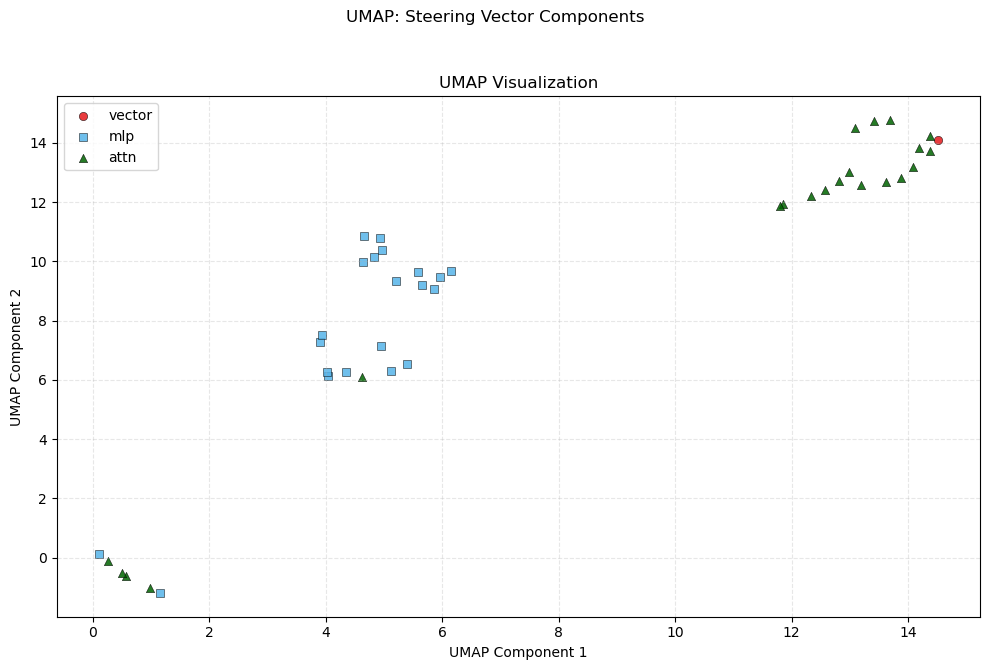

[[ 4.631204    6.1120553 ]
 [ 0.5817262  -0.61885434]
 [ 0.5120141  -0.52085936]
 [ 0.98069644 -1.0386382 ]
 [ 0.26596233 -0.12690058]
 [12.983241   13.025661  ]
 [12.333398   12.207985  ]
 [12.57613    12.427934  ]
 [14.073425   13.1781225 ]
 [12.81446    12.706394  ]
 [13.868663   12.809071  ]
 [13.195894   12.57953   ]
 [13.086044   14.489597  ]
 [13.61867    12.670589  ]
 [13.411691   14.729866  ]
 [11.850687   11.936784  ]
 [14.37402    13.718214  ]
 [13.68429    14.77645   ]
 [14.183638   13.835986  ]
 [11.800455   11.868806  ]
 [14.371409   14.247987  ]]


In [ ]:
rng = np.random.default_rng(42)

for study_idx in range(10):
    vector_idx = rng.choice(len(gemma_2_data.keys()), size=5, replace=False)
    vectors = per_steering_vector[:, vector_idx, :]
    X_tsne, X_umap = run_tsne_umap(vectors.reshape(vectors.shape[0], -1))
    create_graph(X_umap, id=study_idx)
    print(X_umap[[i for i in range(1,len(X_umap),2)]])
